# Example: Solving the one dimensional Poisson equation

Here, the function $g(x)$ to solve for follows the equation 

$$ \label{ode}
-g''(x) = f(x),\qquad \qquad x \in (0,1)
$$

where $f(x)$ is a given function, along with the chosen conditions

$$ 
\begin{aligned} 
g(0) = g(1) = 0 
\end{aligned}\label{cond}
$$

In this example, we consider the case when $f(x) = (3x + x^2)\exp(x)$.

The analytic solution for \eqref{ode} is

$$
g(x) = x(1 - x)\exp(x)
$$

In [1]:
def g_analytic(x):
    return x*(1-x)*np.exp(x)

## Using TensorFlow



Initial cost: 324.099
Final cost: 0.00461895

Max absolute difference between the analytical solution and solution from TensorFlow DNN: 0.000490608


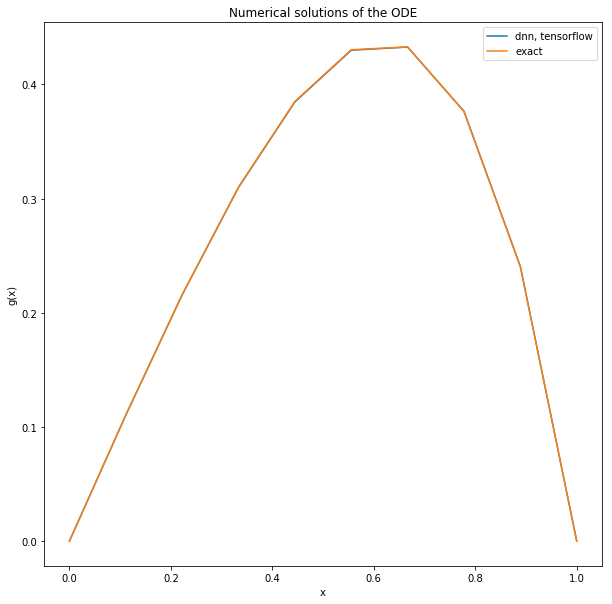

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Construction phase

Nx = 10
x = np.linspace(0,1, Nx)

# Just to reset the graph such that it is possible to rerun this
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()

tf.set_random_seed(4155)

# Convert the values the trial solution is evaluated at to a tensor. 
x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)


num_iter = 10000

# Define the number of neurons at each hidden layer
num_hidden_neurons = [20,10]
num_hidden_layers = np.size(num_hidden_neurons)

# Construct the network. 
# tf.name_scope is used to group each step in the construction,
# just for a more organized visualization in TensorBoard
with tf.name_scope('dnn'):
    
    # Input layer
    previous_layer = x_tf
    
    # Hidden layers
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1), activation=tf.nn.sigmoid)
        previous_layer = current_layer
    
    # Output layer
    dnn_output = tf.layers.dense(previous_layer, 1, name='output')

# Define the cost function
with tf.name_scope('cost'):
    g_trial = x_tf*(1-x_tf)*dnn_output
    d_g_trial = tf.gradients(g_trial,x_tf)
    d2_g_trial = tf.gradients(d_g_trial,x_tf)
    
    right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)
    
    err = tf.square( -d2_g_trial[0] - right_side)
    cost = tf.reduce_sum(err, name = 'cost')

# Choose the method to minimize the cost function, along with a learning rate
learning_rate = 0.001
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    traning_op = optimizer.minimize(cost)

g_dnn_tf = None

# Define a node that initializes all of the other nodes in the computational graph
# used by TensorFlow:
init = tf.global_variables_initializer()


## Execution phase

# Start a session where the graph defined from the construction phase can be evaluated at:

with tf.Session() as sess:
    # Initialize the whole graph
    init.run()
   
    # Evaluate the initial cost:
    print('Initial cost: %g'%cost.eval())
    
    # The traning of the network:
    for i in range(num_iter):
        sess.run(traning_op)
        
    # Training is done, and we have an approximate solution to the ODE
    print('Final cost: %g'%cost.eval())
    
    # Store the result
    g_dnn_tf = g_trial.eval()
    
    # Write the grapf such that it can be visualized in TensorBoard
    writer = tf.summary.FileWriter("./output", sess.graph)
    writer.close()

g_analytical = g_analytic(x)
diff_tf = g_dnn_tf - g_analytical.reshape(-1,1)

print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN: %g'%np.max(np.abs(diff_tf)))

# Plot the result
plt.figure(figsize=(10,10))

plt.title('Numerical solutions of the ODE')

plt.plot(x, g_dnn_tf)
plt.plot(x, g_analytical)

plt.legend(['dnn, tensorflow', 'exact'])
plt.xlabel('x')
plt.ylabel('g(x)')

plt.show()

## Comparing with a numerical scheme

The equation \eqref{ode} is possible to solve using Taylor series to approximate the second derivative. 

Using Taylor series, the second derivative can be expressed as

$$
g''(x) = \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2} + E_{\Delta x}(x)
$$
where $\Delta x$ is a small step size and $E_{\Delta x}(x)$ being the error term. Looking away from the error terms gives an approximation to the second derivative

$$ \label{approx}
g''(x) \approx \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2}
$$

If $x_i = i \Delta x = x_{i-1} + \Delta x$ and $g_i = g(x_i)$ for $i = 1,\dots N_x - 2$ with $N_x$ being the number of values for $x$, \eqref{approx} becomes

$$
\begin{aligned}
g''(x_i) &\approx \frac{g(x_i + \Delta x) - 2g(x_i) + g(x_i -\Delta x)}{\Delta x^2} \\
&= \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2}
\end{aligned}
$$

Since we know from \eqref{ode} that

$$
\begin{aligned}
-g''(x) &= f(x) \\
&= (3x + x^2)\exp(x)
\end{aligned}
$$

along with the conditions \eqref{cond} that $g(0) = g(1) = 0$, the following scheme can be used to find an approximate solution for $g(x)$ numerically:

$$ 
\begin{aligned}
-\Big( \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2} \Big) &= f(x_i) \\
-g_{i+1} + 2g_i - g_{i-1} &= \Delta x^2 f(x_i)
\end{aligned}\label{odesys}
$$

for $i = 1, \dots, N_x - 2$ where $g_0 = g_{N_x - 1} = 0$ and $f(x_i) = (3x_i + x_i^2)\exp(x_i)$ from \eqref{ode}. 

Equation \eqref{odesys} can be rewritten into a matrix equation

$$
\begin{aligned}
\begin{pmatrix}
2 & -1 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
\vdots & & \ddots & & \vdots \\
0 & \dots & -1 & 2 & -1  \\
0 & \dots & 0 & -1 & 2\\
\end{pmatrix}
\begin{pmatrix}
g_1 \\
g_2 \\
\vdots \\
g_{N_x - 3} \\
g_{N_x - 2}
\end{pmatrix}
&=
\Delta x^2
\begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_{N_x - 3}) \\
f(x_{N_x - 2})
\end{pmatrix} \\
A\vec{g} &= \vec{f}
\end{aligned}
$$
which makes it possible to solve for the vector $\vec{g}$.

Max absolute error between analytical and finite difference: 0.00266858


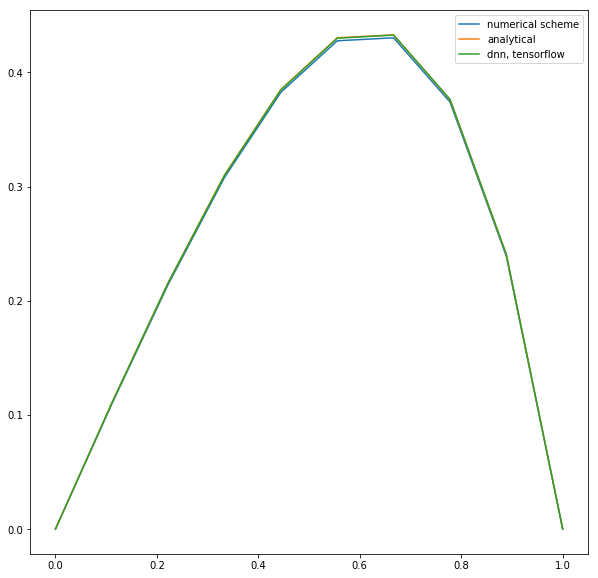

In [6]:
def f(x):
    return (3*x + x**2)*np.exp(x)
dx = 1/(Nx - 1)

# Set up the matrix A 
A = np.zeros((Nx-2,Nx-2))

A[0,0] = 2
A[0,1] = -1 

for i in range(1,Nx-3):
    A[i,i-1] = -1
    A[i,i] = 2
    A[i,i+1] = -1
    
A[Nx - 3, Nx - 4] = -1
A[Nx - 3, Nx - 3] = 2

# Set up the vector f 
f_vec = dx**2 * f(x[1:-1])

# Solve the equation
g_res = np.linalg.solve(A,f_vec)

g_vec = np.zeros(Nx)
g_vec[1:-1] = g_res

print("Max absolute error between analytical and finite difference: %g"%np.max(np.abs(g_vec - g_analytical)))

plt.figure(figsize=(10,10))

plt.plot(x,g_vec)
plt.plot(x,g_analytical)
plt.plot(x,g_dnn_tf)

plt.legend(['numerical scheme','analytical','dnn, tensorflow'])
plt.show()

## Using a different optimization algorithm implemented in TensorFlow

We can see that the results using Gradient Descent seems to converge towards the analytical solution. 
But there exists many other methods for optimization also, see [the TensorFlow documentation](https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers). 

Adam is an optimization algorithm that is adaptive and changes its learning paramaters accordingly to the function it tries to minimize. The algorithm is described in [this paper](https://arxiv.org/pdf/1412.6980.pdf). Here, we will only see the effect of choosing a different optimizer. 
Using the same TensorFlow program as before, the only change to do, is to replace the variable \textit{optimizer}.

Initial cost: 324.099
Final cost: 0.000345773

Max absolute difference between the analytical solution and solution from TensorFlow DNN: 7.11243e-05


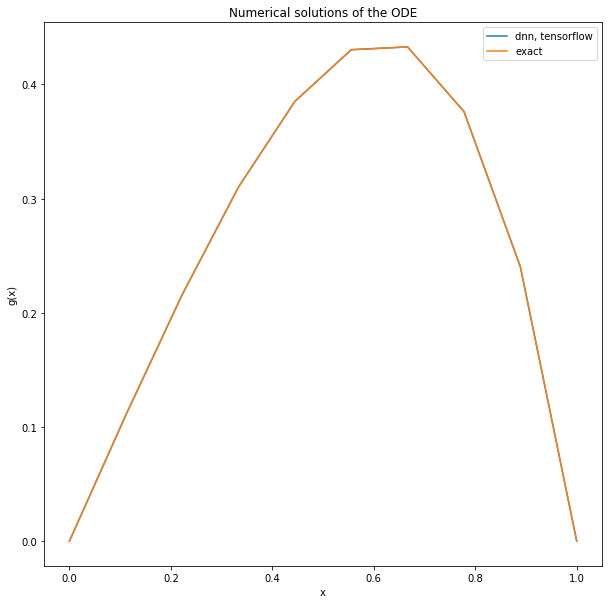

In [7]:
tf.reset_default_graph()
tf.set_random_seed(4155)

x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)


num_iter = 10000

num_hidden_neurons = [20,10]
num_hidden_layers = np.size(num_hidden_neurons)

with tf.name_scope('dnn'):
    previous_layer = x_tf

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1), activation=tf.nn.sigmoid)
        previous_layer = current_layer
    
    dnn_output = tf.layers.dense(previous_layer, 1, name='output')

with tf.name_scope('cost'):
    g_trial = x_tf*(1-x_tf)*dnn_output
    d_g_trial = tf.gradients(g_trial,x_tf)
    d2_g_trial = tf.gradients(d_g_trial,x_tf)
    
    right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)
    
    err = tf.square( -d2_g_trial[0] - right_side)
    cost = tf.reduce_sum(err, name = 'cost')

learning_rate = 0.001
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate) 
    traning_op = optimizer.minimize(cost)

g_dnn_tf = None

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()

    print('Initial cost: %g'%cost.eval())

    for i in range(num_iter):
        sess.run(traning_op)

    print('Final cost: %g'%cost.eval())

    g_dnn_tf = g_trial.eval()
    

diff_tf = g_dnn_tf - g_analytical.reshape(-1,1)

print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN: %g'%np.max(np.abs(diff_tf)))

# Plot the result
plt.figure(figsize=(10,10))

plt.title('Numerical solutions of the ODE')

plt.plot(x, g_dnn_tf)
plt.plot(x, g_analytical)

plt.legend(['dnn, tensorflow', 'exact'])
plt.xlabel('x')
plt.ylabel('g(x)')

plt.show()